### The Dataset is stored in the ```dataset``` folder 
downloaded from ```http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip```
### The GloVe vector embeddings are in the ```glove``` folder 
downloaded from ```https://github.com/stanfordnlp/GloVe```
### The Counter-Fitted vectors are in the ```counter-fitted``` folder
download from ```https://github.com/nmrksic/counter-fitting/blob/master/word_vectors/counter-fitted-vectors.txt.zip```
(see referenced paper [20])


# Import dependecies 
Start by importing all the required libraries

In [107]:
"""
Python 3.8
Tensorflow 2.3.1
Keras 2.4.3

wordcloud 1.8.0
"""
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import random as rnd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import pickle
import os
import re
from keras.preprocessing.text import Tokenizer

############ CONSTANTS ##################################

# DATA FILE LOCATIONS
DATA_SET = "dataset/train.csv"
COUNTER_FITTED_vectors = "counter-fitted/counter-fitted-vectors.txt" 
GLOVE_EMBEDDINGS = "glove/glove.840B.300d.txt"

# DATA SPLIT & VOCABULARY SIZE
TRAINING_SPLIT = 0.8
MAXIMUM_VOCABULARY = 50000
MAX_TEXT_LENGTH = 40

# Process dataset
### Read the dataset file and return a data frame


In [81]:
def process_dataset_Sentiment140(file_path: str ):
    # load the data file into a data frame
    df = pd.read_csv(file_path,encoding = 'latin',header=None)
    
    # Rename the columns so we can reference them later
    df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
    
    # drop all the columns we don't need
    df = df.drop(['id', 'date', 'query', 'user_id'], axis=1) 
    
    # change all 4's to 1's (just for neatness)
    df.loc[df['sentiment'] == 4, 'sentiment'] = 1
    
    # sort all the rows by the sentiment columns
    df.sort_values(by=['sentiment'])
    
    return df
    

### Read in the dataset file and show the first 5 rows of the data frame


In [82]:
data_frame = process_dataset_Sentiment140(DATA_SET)
data_frame.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Plot the data
#### We see that we have 2 types of sentiments, ```0 = negative``` and ```1 = positive```. We have 800,000 data points for each type of sentiment

Text(0.5, 1.0, 'Sentiment Distribution')

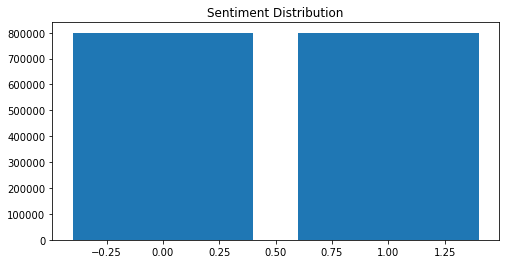

In [83]:
val_count = data_frame.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Distribution")

### We need to remove hyperlinks from the text - define a regex here to use

In [84]:
"""
preprocess-twitter.py

python preprocess-twitter.py "Some random text with #hashtags, @mentions and http://t.co/kdjfkdjf (links). :)"

Script for preprocessing tweets by Romain Paulus
with small modifications by Jeffrey Pennington
with translation to Python by Motoki Wu (github.com/tokestermw)

Translation of Ruby script to create features for GloVe vectors for Twitter data.
http://nlp.stanford.edu/projects/glove/preprocess-twitter.rb

this version from gist.github.com/ppope > preprocess_twitter.py

light edits by amackcrane, mostly inspired by the test case given at bottom
"""
FLAGS = re.MULTILINE | re.DOTALL

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = "<hashtag> {} <allcaps>".format(hashtag_body.lower())
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps> " # amackcrane added trailing space


def tokenize(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\w+", hashtag)  # amackcrane edit
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")
    

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    #text = re_sub(r"([A-Z]){2,}", allcaps)  # moved below -amackcrane

    # amackcrane additions
    text = re_sub(r"([a-zA-Z<>()])([?!.:;,])", r"\1 \2")
    text = re_sub(r"\(([a-zA-Z<>]+)\)", r"( \1 )")
    text = re_sub(r"  ", r" ")
    text = re_sub(r" ([A-Z]){2,} ", allcaps)
    
    return text.lower()


# decided to use this regex instead of the above script
# we are using the glove 300d embeddings rather than the twitter glove embeddings
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9']+"

### Use the regex to clean all our text entries and write back to the data frame

In [85]:
def clean_text(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    return text

In [86]:
data_frame.text = data_frame.text.apply(lambda x: clean_text(x))

In [87]:
data_frame.head()

,sentiment,text
0,0,awww that's a bummer you shoulda got david car...
1,0,is upset that he can't update his facebook by ...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no it's not behaving at all i'm mad why am i h...


# Wordcloud of ```positive``` sentiments

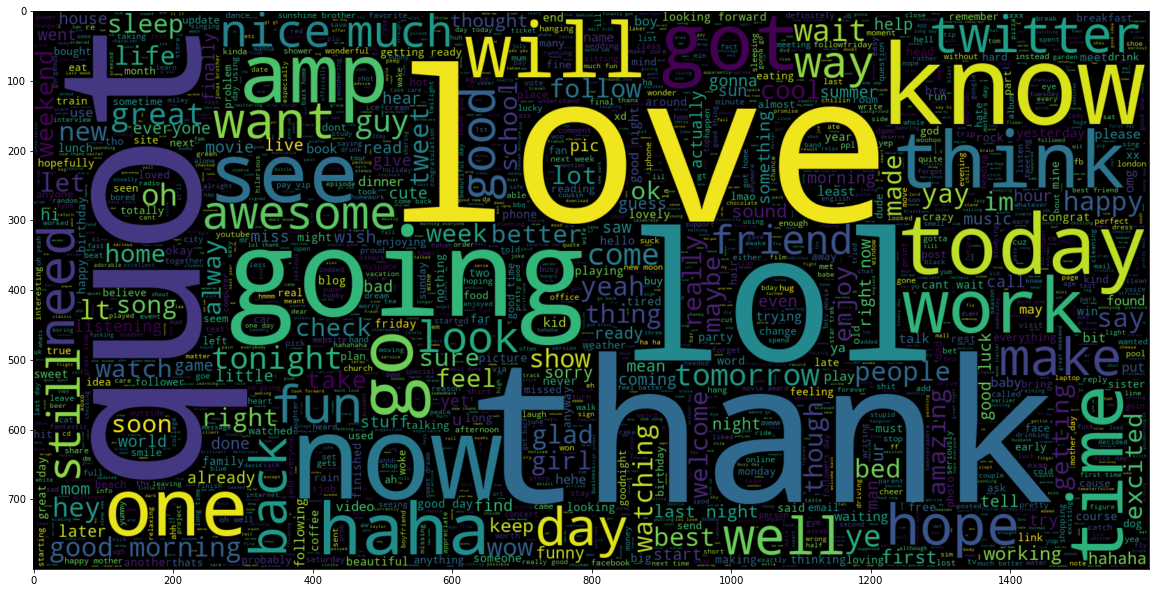

In [88]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

# Wordcloud of ```negative``` sentiments

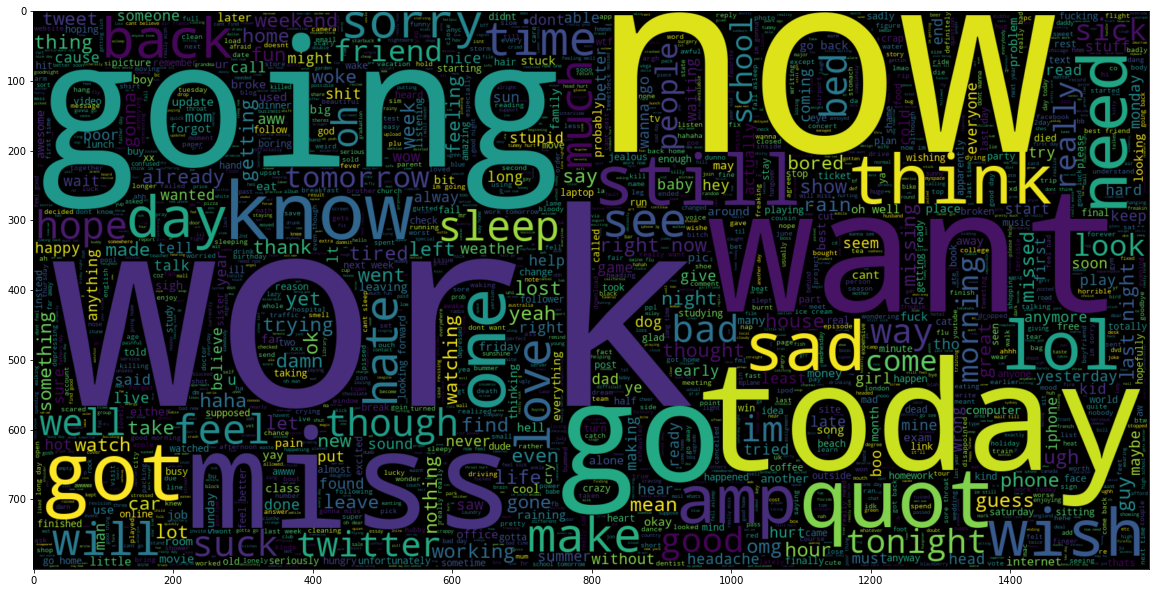

In [89]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

### Now we need randomise the dataset

In [90]:
data_frame = data_frame.sample(frac = 1, random_state = 7) # frac = 1 i.e. the entire data frame, random_state = Seed for the random number generator 

In [91]:
data_frame.head()

,sentiment,text
709290,0,feelin down lately but i've no reason too
654075,0,with ju clare elly and zoe about to leave marb...
728623,0,wish i couldve seen miley and nick sing 2night
697650,0,had to work today 1 hour down 6 to go
1244425,1,just started to catch up on house viewing kind...


### Now we split the data set into 80% for training and 20% for testing
#### This will also shuffle the data set before splitting it

In [102]:
train_size, test_size = train_test_split(data_frame, test_size= (1 - TRAINING_SPLIT), random_state = 7)

In [93]:
print("Training Data:\t",len(train_size), " data points")
print("Test Data:\t",len(test_size), " data points")

Training Data:	 1280000  data points
Test Data:	 320000  data points


### Examine the training and test data sets

#### Training dataset

In [94]:
train_size.head()

,sentiment,text
891695,1,is loving his new table from ikea which he got...
976601,1,you got this can't wait to here some new from ...
17324,0,heh actually getting pretty sleepeh so i'm off...
775910,0,cleaning the kitchen
401516,0,waiting for a wii system update to finish feel...


#### Testing dataset

In [95]:
test_size.head()

,sentiment,text
1427435,1,i wish or i would be buying 1 or 2 lol you'd m...
1101080,1,i hate you right now
1085676,1,up to no good as always
1025165,1,means so much chris thanks
760122,0,winter classes early empire pop culture peopli...




# Tokenization of training data
- We will use the TensorFlow (Keras) Tokenizer class to tokenize our training data (see imports above)
- We define some hyperparameters we will use when performing tokenization
- First we create the Tokenizer object as well as an out of vocabulary token (oov_token) to use for encoding test data words we have not come across in our training, if we don't do this then previously-unseen words would never be unaccounted for. 
- After the Tokenizer has been created, we then fit it on the training data (we do the same for our test dataset).

<center>
<img src="images/tokenization-manning.png">
</center>



    
<center><strong>Francois Chollet. 2017. Deep Learning with Python (1st. ed.). Manning Publications Co., USA.</strong></center>
    


In [112]:
# hyper parameters provided to tokenizer

"""
the UNK token which will be used for out of vocabulary tokens encountered during the 
tokenizing and encoding of the test data sequences created using the word index built during 
tokenization of our training data.
"""
oov_token = '<UNK>'


"""
When we are encoding our numeric sequence representations of the text data, our tweet
string lengths will be of different lengths and so we will need to select a maximum length 
for tweets and pad shorter tweets with a padding character.

We will first calculate the size of the largest tweet string, and then use '0' as a padding character, to pad out shorter
tweets. This ensures all our sequenes of text are of the same length.

Here are specifying that we want the padding at the end of the sequence of tokens
"""
pad_type = 'post'



In [113]:
# Tokenize training data 
tokenizer = Tokenizer(oov_token=oov_token)

# fit to our training dataset
tokenizer.fit_on_texts(train_size.text)


# store the training datas word_index
"""
The okenization process also creates a word index. This  maps words in our 
vocabulary to their numeric representation.

This mapping is then used to encoding our sequences. 
"""
word_index = tokenizer.word_index



# Encode the training tweet sentence into sequences
"""
After tokenizing our training data we have a word-to-numeric 
mapping of our vocabulary, this is used to encode our sequences. 

Here, we are converting our text sentences from something  like 
"the cat sat on the mat" to something like "3 6 7 2 1 4" where each of 
these numbers matches to the index of the corresponding words. 

Since Neural Networks work erforming computation on numbers, 
passing in set of strings will not work. Which is why we need these sequences.

So far, this is only the training dataset, the test dataset has to be
tokenized and encoded after we have competed the training dataset.
"""
train_sequences = tokenizer.texts_to_sequences(train_size.text)

# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, maxlen=maxlen)

print("Word Index:", type(word_index))
print("Training sequences data type:", type(train_sequences))
print("Padded Training sequences data type:", type(train_padded))

# vocab_size = len(tokenizer.word_index) + 1
# dataset_size = tokenizer.document_count



Word Index: <class 'dict'>
Training sequences data type: <class 'list'>
Padded Training sequences data type: <class 'numpy.ndarray'>


In [127]:
print("\nPadded training shape:", train_padded.shape)

print("\nExample Training sequences:\n",train_sequences[1])
print("\nExample Padded training sequences:\n",train_padded[0])



Padded training shape: (1280000, 52)

Example Training sequences:
 [8, 48, 27, 68, 138, 3, 89, 69, 76, 52, 287, 176, 13, 323]

Example Padded training sequences:
 [     9    699    189     76   1883     52   3719    395    110     48
     12      4     84      9   2580     11   2441     83     70   6478
   2075    250     81      3 110608      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0]


# Training data word_index

In [99]:
print("Size of Vocabulary :", vocab_size)
print("dataset_size:\t", dataset_size)


# Encode training data sentences into sequences
# train_sequences = tokenizer.texts_to_sequences(train_data)
train_sequences = tokenizer.texts_to_sequences(train_size.text)

# Get maximum training sequence length
maxlen = max([len(x) for x in train_sequences])

print("MAX_TEXT_SEQUENCE:\t", maxlen)


# x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen = MAX_TEXT_LENGTH)
# x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen = MAX_TEXT_LENGTH)

# print("Training X Shape:",x_train.shape)
# print("Testing X Shape:",x_test.shape)

Size of Vocabulary : 309707
dataset_size:	 1280000
MAX_TEXT_SEQUENCE:	 49


Francois Chollet. 2017. Deep Learning with Python (1st. ed.). Manning Publications Co., USA.